#### Load the modules and set some figure plotting characteristics

In [1]:
%pylab inline
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd
import my_functions as my

plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 16}

matplotlib.rc('font', **font)

rc('ytick.major', size=4)
rc('xtick.major', size=4)
rc('ytick.minor', size=4)
rc('xtick.minor', size=4)
rc('lines', linewidth=1.5)

Populating the interactive namespace from numpy and matplotlib


#### Figure 1
---

Map of the deployment location, sea ice distribution, sea ice hovmoller

Sea ice data source: http://data.meereisportal.de/data/iup/hdf/s/

In [3]:
# Load the interpolated sea ice concentration dataset 
sic = xr.open_dataset('../data/seaice/sic_interp.nc')

#### Plot a hovmoller of the sea ice concentration during the deployment along the 0E longitudinal line

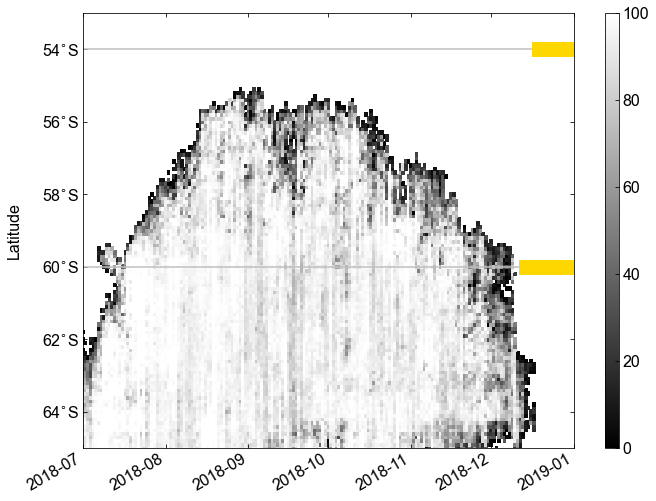

In [4]:
fig,ax=subplots(figsize=[11, 8])

# select data along the GH line, 0E
ds=sic.sic.isel(lon=1800) 

# plot the hovmoller
ds.T.plot(cmap='gray', ax=ax, vmin=0, vmax=100, cbar_kwargs={'label': '', 'aspect': 30})

# # set the plot limits
ax.set_ylim(-65, -53)
ax.set_xlim('2018-07-01', '2019-01-01')

ax.plot(ds.time, np.zeros(len(ds.time))-60, c='0.75', ls='-')
ax.plot(ds.time, np.zeros(len(ds.time))-54, c='0.75', ls='-')

ax.yaxis.set_ticks(np.arange(-64, -52, 2))
ax.yaxis.set_ticklabels(['64$^{\circ}$S', '62$^{\circ}$S', '60$^{\circ}$S', '58$^{\circ}$S', '56$^{\circ}$S', '54$^{\circ}$S'])

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('Latitude', labelpad=20)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

d = pd.date_range(start='2018-12-19', end='2019-01-31',freq='1D')
ax.plot(d, np.zeros(len(d))-54, lw=15, c='gold')

d = pd.date_range(start='2018-12-14', end='2019-01-31',freq='1D')
ax.plot(d, np.zeros(len(d))-60, lw=15, c='gold')

# scatter(pd.to_datetime('2018-12-19T16:09:34'), -54, s=150, marker='s', facecolor='w', edgecolor='gold', lw=4, zorder=10)
# scatter(pd.to_datetime('2018-12-14T21:56:37'), -60, s=150, marker='s', facecolor='w', edgecolor='gold', lw=4, zorder=10)

# ax.text(-59.5, pd.to_datetime('2018-12-18'), 'Gliders deployed', c='y', fontsize=18, fontweight='bold')

savefig('../figures/seaice_hov.png', dpi=300, bbox_inches='tight')

#### Load the absolute dynamic topography for the frontal locations 

In [ ]:
adt = xr.open_mfdataset('../data/adt/nrt*.nc')

# adjust the longitudes from (0, 360) to (-180, 180)
adt = my.adjust_lon_xr_dataset(adt, lon_name='longitude')

# get the mean adt for the deployment
adt_mean = adt.mean(dim='time')
adt_mean['gos'] = (('latitude', 'longitude'), np.sqrt(adt_mean.ugos**2 + adt_mean.vgos**2))

# calculate eke
u_mean = adt.ugos.mean(dim='time')
v_mean = adt.vgos.mean(dim='time')

u_prime = adt.ugos-u_mean
v_prime = adt.vgos-v_mean

eke = ((u_prime**2 + v_prime**2)/2).mean(dim='time')

### Frontal detection 

Using the methods of Swart et al. (2010) An altimetry-based gravest empirical mode south of Africa: 1. Development and validation (Figure 8)

In [7]:
import gsw

dist_adt = gsw.distance(np.zeros(len(adt_mean.latitude)), adt_mean.latitude.values)[0]

adt_diff_lat = adt_mean.latitude[1:].values
adt_diff = 100000 * adt_mean.adt[:,720].diff(dim='latitude').values / dist_adt

### Plot Southern Ocean Fronts

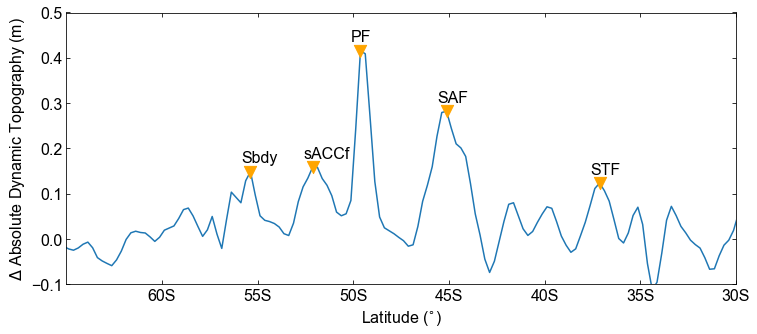

In [8]:
fig,ax=subplots(figsize=[12, 5])

ax.plot(adt_diff_lat, adt_diff)
ax.set_xlim(-65, -30)
ax.set_ylim(-0.1, 0.5)

idx = [137, 150, 160, 178, 210]
fnt = ['Sbdy', 'sACCf', 'PF', 'SAF', 'STF']

for i, val in enumerate(idx):
    
    ax.scatter(adt_diff_lat[val], adt_diff[val], s=150, c='orange', marker='v', zorder=10)
    ax.text(   adt_diff_lat[val] - 0.5,  adt_diff[val] + 0.02, str(fnt[i]))

# plotting 
ax.xaxis.set_ticks([-60, -55, -50, -45, -40, -35, -30])
ax.xaxis.set_ticklabels(['60S','55S','50S','45S','40S','35S','30S'])

ax.set_ylabel('$\Delta$ Absolute Dynamic Topography (m)')
ax.set_xlabel('Latitude ($^{\circ}$)')

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

savefig('../figures/adt_grad_front_detection.png', dpi=300, bbox_inches='tight')

In [9]:
front_contours = adt_mean.adt[:,720][idx].values

### Determine sea ice max contour

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/glidertools/helpers.py:70: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


(-20.0, 20.0)

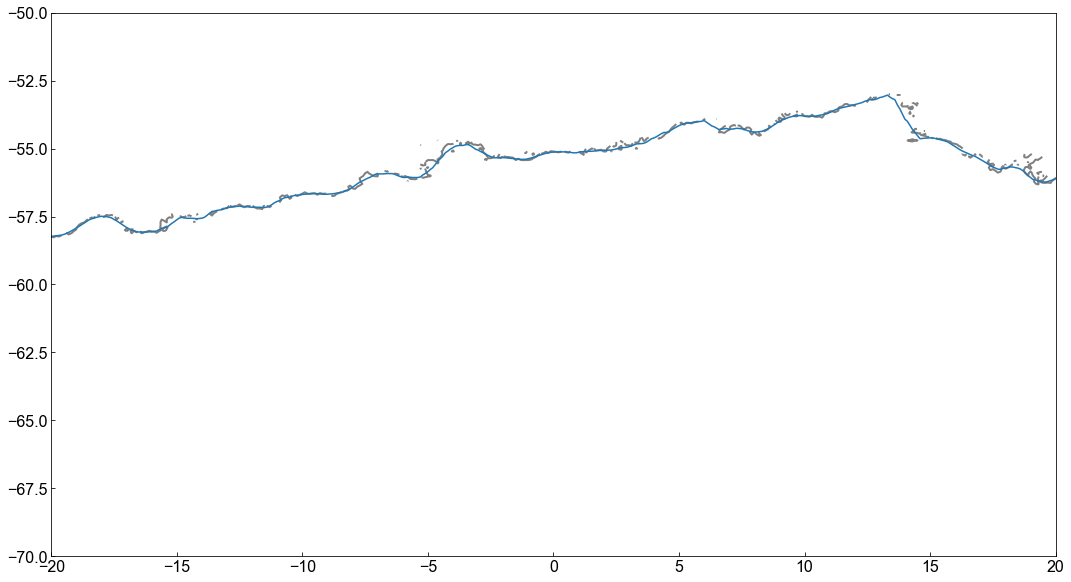

In [10]:
sic_mnth=sic.sic.resample(time='1M').mean()

cs = contour(sic.lon, sic.lat, sic_mnth.sel(time='2018-09-30'), levels=[15], colors='0.5', linewidths=2)

for i in range(len(cs.allsegs[0])):
    
    if i==0:
        lon=cs.allsegs[0][i][:,0]
        lat=cs.allsegs[0][i][:,1]
        
    if i>0:
        lon = np.append(lon, cs.allsegs[0][i][:,0])
        lat = np.append(lat, cs.allsegs[0][i][:,1])

lon = lon[lat>-66]
lat = lat[lat>-66]
        
new_lon = np.arange(-180,180.05,0.1)
        
for i, ln in enumerate(new_lon):
    
    idx = ((lon>ln) & (lon<ln+0.1))
    
    if i==0:
        new_lat = np.median(lat[idx])
    if i>0:
        try:
            new_lat = np.append(new_lat, np.min(lat[idx]))
        except:
            new_lat = np.append(new_lat, np.nan)

import glidertools as gt

new_lat = gt.cleaning.rolling_window(new_lat, func=np.nanmean, window=10)

plot(new_lon, new_lat)

xlim(-20, 20)

### Plot EKE map 

In [11]:
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 20}

matplotlib.rc('font', **font)

<ipython-input-13-382549630b34>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h_sp = ax.pcolormesh(adt_mean.longitude, adt_mean.latitude, eke, norm=LogNorm(vmin=1e-5, vmax=1e-1), cmap='YlGnBu_r')


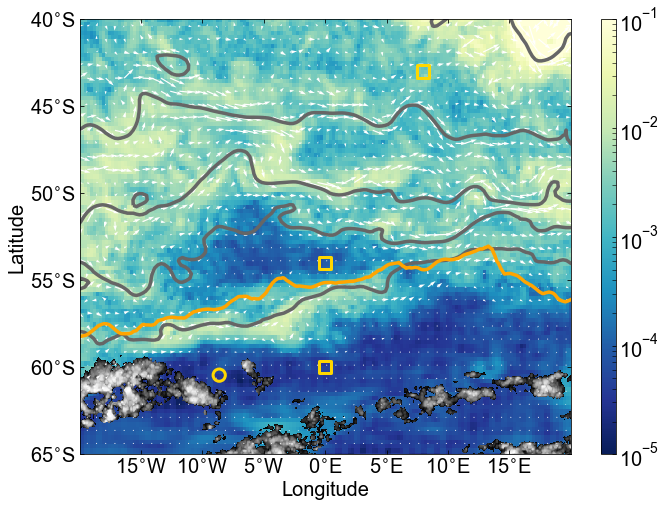

In [13]:
from matplotlib.colors import LogNorm

fig,ax=subplots(figsize=[11,8])

h_sp = ax.pcolormesh(adt_mean.longitude, adt_mean.latitude, eke, norm=LogNorm(vmin=1e-5, vmax=1e-1), cmap='YlGnBu_r')
h_fr = ax.contour( adt_mean.longitude, adt_mean.latitude, adt_mean.adt, levels=front_contours, colors='0.4', linewidths=3.5, linestyles='-')

h_si = ax.plot    (new_lon, new_lat, color='orange', linewidth=3.5)
h_si = ax.contourf(sic.lon, sic.lat, sic.sic.sel(time='2018-12-14'), levels=np.arange(15, 101, 1), cmap='gray')

ax.set_xlim(-20, 20)
ax.set_ylim(-65, -40)

cb=colorbar(mappable=h_sp, aspect=30)
cb.set_ticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
ax.scatter([0, 0, 8], [-60, -54, -43], s=150, marker='s', facecolor='none', edgecolor='gold', zorder=100, linewidth=3)
ax.scatter([-8.63], [-60.45,], s=150, marker='o', facecolor='none', edgecolor='gold', zorder=100, linewidth=3)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.xaxis.set_ticks([-15, -10, -5, 0, 5, 10, 15])
ax.xaxis.set_ticklabels(['15$^{\circ}$W','10$^{\circ}$W','5$^{\circ}$W','0$^{\circ}$E','5$^{\circ}$E','10$^{\circ}$E','15$^{\circ}$E'])

ax.yaxis.set_ticks([-65, -60, -55, -50, -45, -40])
ax.yaxis.set_ticklabels(['65$^{\circ}$S','60$^{\circ}$S','55$^{\circ}$S','50$^{\circ}$S','45$^{\circ}$S','40$^{\circ}$S'])

ax.quiver(adt_mean.longitude[::3], adt_mean.latitude[::3], adt_mean.ugos[::3, ::3], adt_mean.vgos[::3, ::3], color='w', scale=1e1)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

savefig('../figures/fig1_map.png', dpi=300, bbox_inches='tight')

### EN4 climatology figure

Using interpolated data from 2002-2019

In [15]:
en4=xr.open_mfdataset('../data/EN4/*.nc')

In [16]:
import my_functions as my

en4 = my.adjust_lon_xr_dataset(en4, lon_name='lon')
clim = en4.groupby('time.season').mean('time', keep_attrs=True).sel(season='DJF', lon=slice(-5, 10)).mean(dim='lon').sel(lat=slice(-70, -20))

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/marcel/

In [17]:
clim['density'] = (('depth', 'lat'), gsw.rho(clim.salinity, clim.temperature-273.15, clim.depth/1000))

In [18]:
mld=my.calc_mld(clim.density.T, clim.depth)

In [19]:
clim = clim.sel(lat=slice(-63, -38), depth=slice(0, 1000))

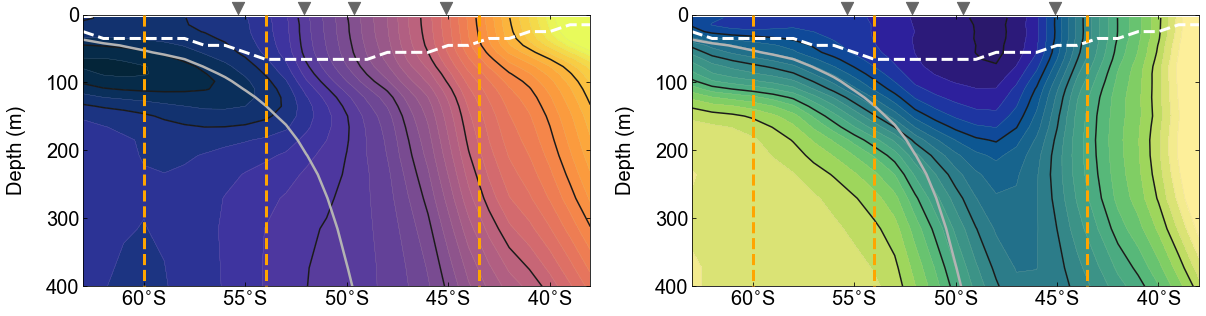

In [20]:
fig, ax = subplots(1, 2, figsize=[20, 5])

# plot the temperature
h0=ax[0].contourf(clim.lat, 
                  clim.depth, 
                  clim.temperature-273.15,
                  levels=np.arange(-2, 15, 0.5),
                  cmap=cmo.thermal,
                  extend='both'
                 )

h0=ax[0].contour (clim.lat, 
                  clim.depth, 
                  clim.temperature-273.15,
                  levels=np.arange(-2, 15, 0.5),
                  colors='0.75',
                  linestyles='-',
                  linewidths=0.25,
                  alpha=0.5
                 )

lbs = [-1, 0, 2, 4, 7, 10, 12]

h0=ax[0].contour (clim.lat, 
                  clim.depth, 
                  clim.temperature-273.15,
                  levels=lbs,
                  colors='0.1',
                  linestyles='-'
                 )


# plot the salinity

h1=ax[1].contourf(clim.lat, 
                  clim.depth, 
                  clim.salinity,
                  levels=np.arange(33.8, 34.75, 0.05),
                  cmap=cmo.haline,
                  extend='both'
                 )

h1=ax[1].contour (clim.lat, 
                  clim.depth, 
                  clim.salinity,
                  levels=np.arange(33.8, 34.75, 0.05),
                  colors='0.75',
                  alpha=0.5,
                  linewidths=0.25
                 )

lbs = [33.8, 34, 34.2, 34.4, 34.6]

h1=ax[1].contour (clim.lat, 
                  clim.depth, 
                  clim.salinity,
                  levels=lbs,
                  colors='0.1'
                 )

[a.contour(clim.lat, clim.depth, clim.density, levels=[1027.3], colors='0.7', linewidths=2.5) for a in ax]

mld=my.calc_mld(clim.density.T, clim.depth)
[a.plot(clim.lat, mld, c='w', ls='--', lw=3) for a in ax]

for a in ax:
    
    a.set_xlim(-63, -38)
    a.set_ylim(400, 0)
    
    a.xaxis.set_ticks([-60, -55, -50, -45, -40])
    a.xaxis.set_ticklabels(['60$^{\circ}$S', '55$^{\circ}$S', '50$^{\circ}$S', '45$^{\circ}$S', '40$^{\circ}$S'])
    
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    
    a.set_ylabel('Depth (m)', labelpad=20)
    
    for lt in [-43.5, -54, -60]:
    
        h=a.vlines(lt, 0, 400, color='orange', zorder=10, linewidth=3, linestyle='--')
        h.set_clip_on(False)

    
    idx = [137, 150, 160, 178]
    fnt = ['Sbdy', 'sACCf', 'PF', 'SAF', 'STF']

    for i, val in enumerate(idx):
        
        h=a.scatter(adt_diff_lat[val], 
                   -10,
                    s=150,
                   color='0.4',
                   marker='v'
                  )
        
        h.set_clip_on(False)

        
        a.yaxis.set_ticks([400, 300, 200, 100, 0])

savefig('../figures/fig1_sections.png', dpi=300, bbox_inches='tight')